In [68]:
# import libraries

# handle dataset 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import recall_score, precision_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier


import pprint
from tabulate import tabulate

from sklearn import linear_model

from imblearn.over_sampling import SMOTE
# if there is an error, solve by downgrading to install scikit-learn==1.2.2 
# ''' steps : 
# 1. install pip 
# 2. uninstall sci-kit 
# 3. uninstall imblearn
# 4. install sci-kit 1.2.2 
# 5. install imblearn 
# '''


# Data set from https://www.kaggle.com/datasets/yasserh/loan-default-dataset/data

In [5]:


df = pd.read_csv('Loan_Default.csv')
# remove some variables that are redundant 
# year, ID
# Interest_rate_spread and rate_of_interest are dropped due to the fact that their values are NA where the loan has defaulted 
# open credit , secured by, total units : only has one value or too few observations 
df = df.drop(['year', 'ID', 'loan_type', 'loan_purpose', 'Interest_rate_spread', 
              'rate_of_interest', 'open_credit','Upfront_charges','construction_type', 
              'Secured_by', 'Security_Type','total_units'], axis=1)
# print(df['Status'].value_counts())
# print(df.isna().sum())

# Assumption 2 : We focus on mortgage loans 
df = df.dropna(subset=["property_value"])
# Assumption 3 : drop approv in adv that is NA (only small set of samples)
df = df.dropna(subset=["term"])
df = df.dropna(subset=["loan_limit"])
df = df.dropna(subset=["approv_in_adv"])
df = df.dropna(subset=["Neg_ammortization"])
df = df.dropna(subset=["income"])
# Drop rows where sex is not available 
df = df.drop(df[df['Gender'] == 'Not Available'].index)


print("Number of rows : " , len(df.index))
# LTV = Loan to Value -> compares the loan value to the value of the asset being purchased as a part of the loan 
# Property Value 

print(df.columns)
print(df['Status'].value_counts())

        


Number of rows :  120635
Index(['loan_limit', 'Gender', 'approv_in_adv', 'Credit_Worthiness',
       'business_or_commercial', 'loan_amount', 'term', 'Neg_ammortization',
       'interest_only', 'lump_sum_payment', 'property_value', 'occupancy_type',
       'income', 'credit_type', 'Credit_Score', 'co-applicant_credit_type',
       'age', 'submission_of_application', 'LTV', 'Region', 'Status', 'dtir1'],
      dtype='object')
0    100978
1     19657
Name: Status, dtype: int64


In [6]:
# print(df['Neg_ammortization'].head())

# for column_name in df.columns:
#     # Count the number of NA values in the current column
#     na_count = df[column_name].isna().sum()
#     if na_count > 0 : 
#     # Print the result
#         print(f"The column '{column_name}' has {na_count} NA values.")

# print(df.columns)
print(df['loan_limit'].value_counts())


cf     112768
ncf      7867
Name: loan_limit, dtype: int64


In [7]:

categorical_columns = ['loan_limit', 'Gender', 'approv_in_adv', 'Credit_Worthiness',
       'business_or_commercial', 'Neg_ammortization',
       'interest_only', 'lump_sum_payment', 'occupancy_type',
        'credit_type', 'co-applicant_credit_type',
       'age', 'submission_of_application', 'Region']

for i in categorical_columns: 
    df = pd.concat([df,pd.get_dummies(df[i],drop_first=True, prefix=i)],axis=1)
    df = df.drop(i,axis=1)


# Checking Correlation between values 

In [8]:
correlation_matrix = df.corr()

# Exclude diagonal elements
correlation_matrix_no_diagonal = correlation_matrix.mask(
    pd.DataFrame(np.eye(len(correlation_matrix), dtype=bool), correlation_matrix.index, correlation_matrix.columns))

# Display the correlation matrix without diagonal elements
print("Correlation Matrix (excluding diagonal):")
print(correlation_matrix_no_diagonal)

# Check for high absolute correlation coefficients
threshold = 0.8  # You can adjust this threshold based on your criteria
highly_correlated_pairs = []

for i in range(len(correlation_matrix_no_diagonal.columns)):
    for j in range(i):
        correlation = correlation_matrix_no_diagonal.iloc[i, j]
        if abs(correlation) > threshold:
            pair = (correlation_matrix_no_diagonal.columns[i], correlation_matrix_no_diagonal.index[j], correlation)
            highly_correlated_pairs.append(pair)

if highly_correlated_pairs:
    print("\nHighly correlated pairs:")
    for pair in highly_correlated_pairs:
        print(f"{pair[0]} and {pair[1]}: {pair[2]}")
else:
    print("\nNo highly correlated pairs found.")

Correlation Matrix (excluding diagonal):
                                   loan_amount      term  property_value  \
loan_amount                                NaN  0.174069        0.734557   
term                                  0.174069       NaN        0.048861   
property_value                        0.734557  0.048861             NaN   
income                                0.451717 -0.054883        0.415447   
Credit_Score                          0.005377 -0.002933        0.003639   
LTV                                   0.063775  0.209505       -0.442754   
Status                               -0.039615  0.008818       -0.045619   
dtir1                                 0.014500  0.111253       -0.056722   
loan_limit_ncf                        0.258006  0.015988        0.200278   
Gender_Joint                          0.190145  0.021610        0.156026   
Gender_Male                           0.000939  0.010377       -0.028914   
Gender_Sex Not Available             -0.118203 

In [9]:
if highly_correlated_pairs:
    print("\nHighly correlated pairs:")
    for pair in highly_correlated_pairs:
        print(f"{pair[0]} and {pair[1]}: {pair[2]}")
else:
    print("\nNo highly correlated pairs found.")


No highly correlated pairs found.


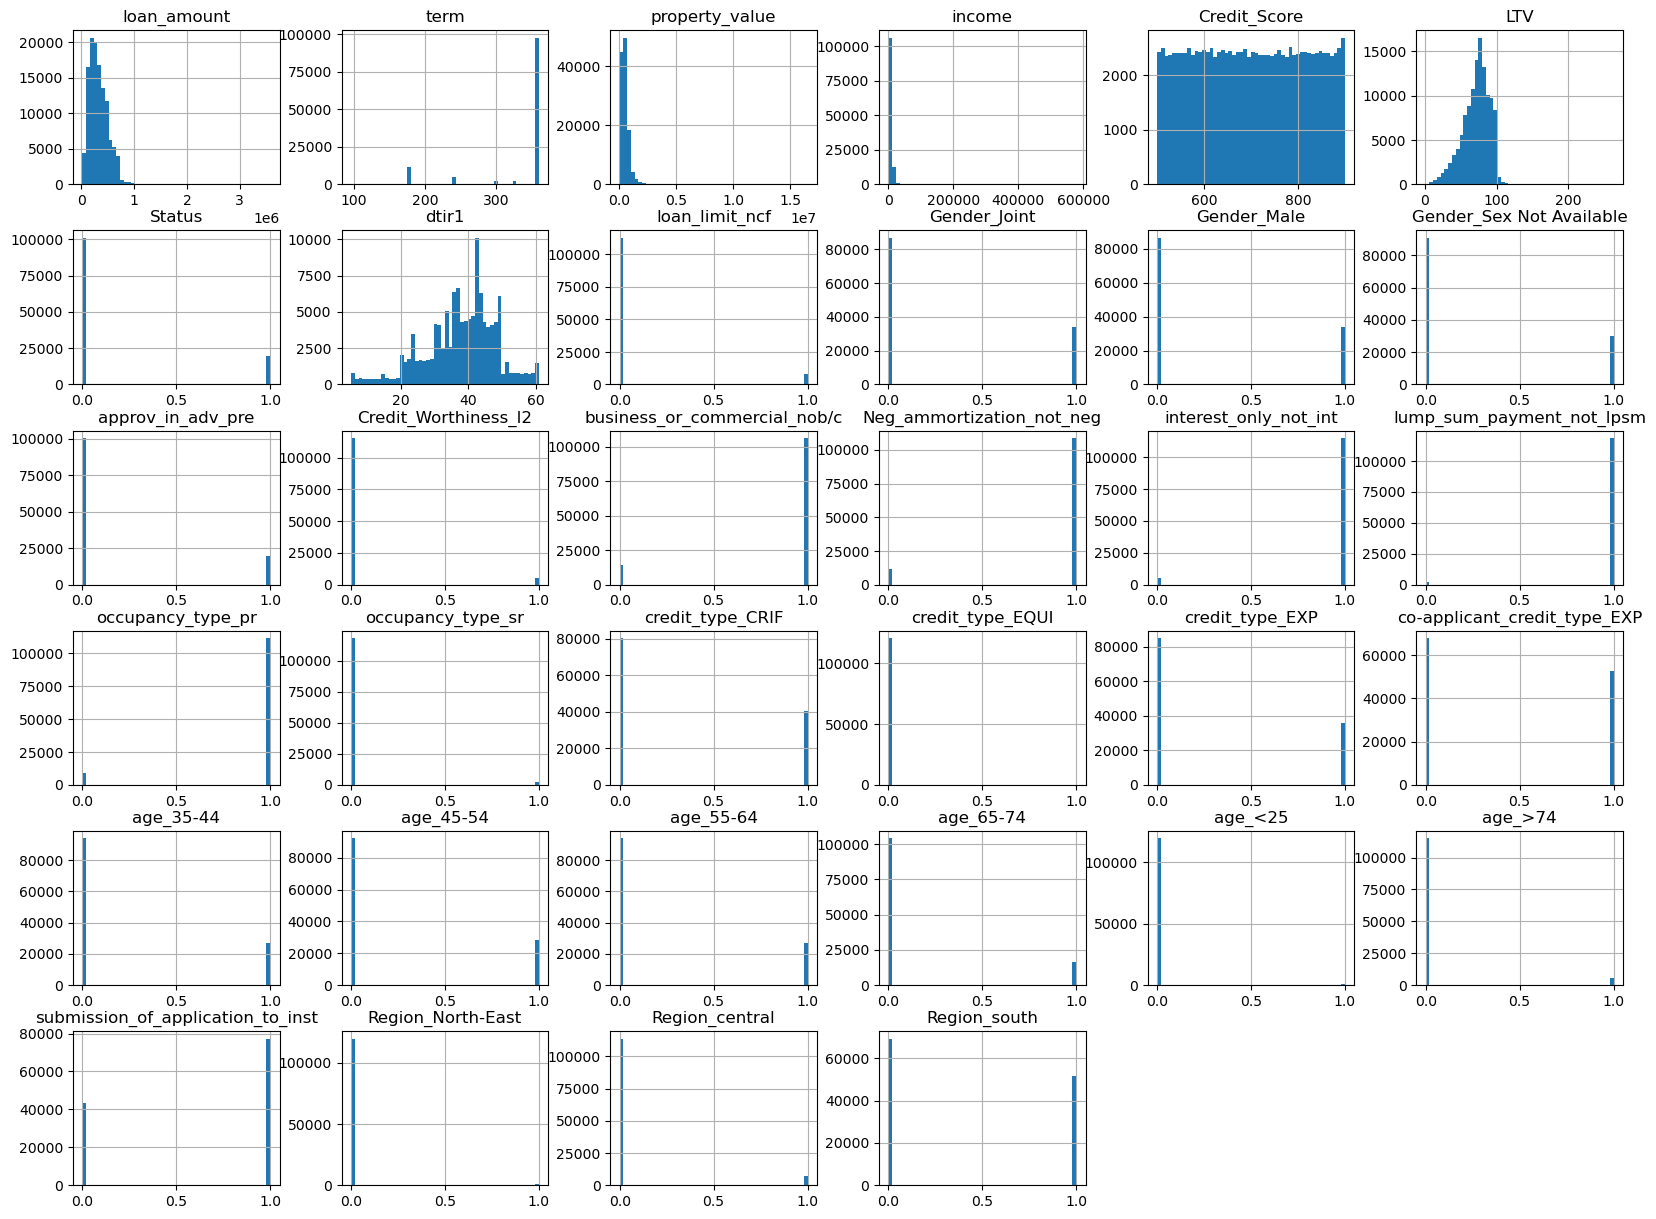

In [10]:
df.hist(bins = 50, figsize = (20, 15))
plt.show()

# Split Train Test dataset

So by looking at the data, we see there are two main types of loans : property loan and non-property loan. 


In [15]:
# define X and y variables as dataframe 
y = df['Status']
X = df.drop('Status',axis=1)
X_train, X_OOS_test, y_train, y_OOS_test = train_test_split(X, y, test_size=0.20, random_state=66)

In [13]:
# non_numeric_columns = X_train.select_dtypes(exclude=['float64', 'int64']).columns
# print("Non-numeric columns:", non_numeric_columns)

## Normalising the values 

In [56]:

# # Normalised the values 
# scaler = StandardScaler()
# # Fit and apply normalization on the training set
# X_train = scaler.fit_transform(X_train)
# # Apply the same normalization rules on the test set
# X_OOS_test = scaler.transform(X_OOS_test)


## Over Sampling 


In [16]:
# Over sample using SMOTE
# -- by inspecting the data, we see that the minority class is extremely class (fraud "Class" == 1)
sm = SMOTE(random_state=42)
X_smote, y_smote = sm.fit_resample(X_train, y_train)

In [141]:
# -- Code to Inspect the data set -- 
# df_oversampled = X_smote
# df_oversampled['Outcome_Variable'] = y_smote
# df_oversampled
# fig, ax = plt.subplots(figsize=(10, 8))
# df_oversampled['Outcome_Variable'].value_counts().plot(kind='bar', ax=ax, fontsize=14)
# ax.set_title('Oversampled Dataset', fontsize=16)
# ax.set_ylabel('Observation counts', fontsize=14)
# ax.set_xlabel('Class', fontsize=14)
# plt.show()

print(y_smote.value_counts())


0    80809
1    80809
Name: Status, dtype: int64


In [17]:
# Set up K-Fold Cross Validation 
n_splits = 5
shuffle = True
random_state = 809
cv = KFold(n_splits=n_splits, shuffle=shuffle, random_state=random_state)
# plot = plot_cv_indices(cv, X_smote, y_smote, n_splits)

## Model 1 : Logistic Regression 

In [9]:
def plot_cv_indices(cv, X, y, n_splits, lw=10):
    '''
    This function plots the Cross validation indices.
    '''
    
    fig, ax = plt.subplots(figsize = (15,8))
    # Generate the training/testing visualizations for each CV split
    for ii, (tr, tt) in enumerate(cv.split(X=X, y=y)):
        # Fill in indices with the training/test groups
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0

        # Visualize the results
        ax.scatter(range(len(indices)), [ii + .5] * len(indices),
                   c=indices, marker='_', lw=lw, cmap=plt.cm.coolwarm,
                   vmin=-.2, vmax=1.2)

    # Plot the data classes
    ax.scatter(range(len(X)), [ii + 1.5] * len(X), c=y, marker='_', lw=lw, cmap=plt.cm.Paired)

    # Formatting
    yticklabels = list(range(n_splits)) + ['Class']
    ax.set(yticks=np.arange(n_splits+1) + .5, yticklabels=yticklabels,
           xlabel='Sample index', ylabel="CV iteration",
           ylim=[n_splits+2.2, -.2])
    ax.set_title('{}'.format(type(cv).__name__), fontsize=15)
    return ax

In [111]:
model = LogisticRegression(solver='lbfgs', max_iter=300)
model.fit(X_smote, y_smote)    
score_OOS = model.score(X_OOS_test, y_OOS_test)
print ("Logistic Model score :" , score_OOS)
y_pred = model.predict(X_OOS_test)
print("Logistic Model Recall : " , recall_score(y_OOS_test, y_pred))
print("Logistic Model Precision : ", precision_score(y_OOS_test,y_pred))
print("Probability if you only predict 0s ", 1-round(95/56867,3))

Logistic Model score : 0.5653002859866539
Logistic Model Recall :  0.634411318847903
Logistic Model Precision :  0.21736495844875348
Probability if you only predict 0s  0.998




# Model 2 : Lasso 

## Cross Validation for LASSO 

In [50]:
# Model 2 : LASSO 
# Cross Validate the penalty term in lasso
cross_validate_result = {}
cross_validate_recall = {} 
cross_validate_precision = {} 

# Set Hyperparameter (Lambda) values to cross validate here !!!!! 
lambdas = [0.001, 0.01, 0.1]
for lambda_value in lambdas:
    print('Training Lasso Lambda Value : ', lambda_value)
    accuracies = []
    recall_scores = [] 
    precision_scores = [] 
    lasso = linear_model.Lasso(alpha=lambda_value)
    for train_index, test_index in cv.split(X_smote):
        # change to loc to define the rows in the dataframe 
        X_cv_train, X_cv_test, y_cv_train, y_cv_test = X_smote.iloc[train_index], X_smote.iloc[test_index], y_smote.iloc[train_index], y_smote.iloc[test_index]
        lasso.fit(X_cv_train, y_cv_train)
        y_pred = lasso.predict(X_cv_test)
        y_pred_classification = [1 if x >= 0.5 else 0 for x in y_pred]

        #Cross-Validation Prediction Error
        score = lasso.score(X_cv_test, y_cv_test)
        accuracies.append(score)
        recall_scores.append(recall_score(y_cv_test, y_pred_classification))
        precision_scores.append(precision_score(y_cv_test,y_pred_classification))

    cross_validate_result[lambda_value] = (sum(accuracies)/len(accuracies))
    cross_validate_recall[lambda_value] = (sum(recall_scores)/len(recall_scores))
    cross_validate_precision[lambda_value] = (sum(precision_scores)/len(precision_scores))

    print("Lambda Value Accuracy : " + str(lambda_value) + " " + str((sum(accuracies)/len(accuracies))))
    print("Lambda Value Precision : " + str(lambda_value) + " " + str((sum(recall_scores)/len(recall_scores))))
    print("Lambda Value Recall : " + str(lambda_value) + " " + str((sum(precision_scores)/len(precision_scores))))
    print() 
# At the end you'll see what the value of each LASSO paramter is
print('------------------')
print('Accuracy : ', cross_validate_result)
print('Precision : ',cross_validate_precision)
print('Recall : ',cross_validate_recall)



    

Training Lasso Lambda Value :  0.001
Lambda Value Accuracy : 0.001 0.490208479329176
Lambda Value Precision : 0.001 0.7885123026124378
Lambda Value Recall : 0.001 0.8743121394471272

Training Lasso Lambda Value :  0.01
Lambda Value Accuracy : 0.01 0.42957536246474304
Lambda Value Precision : 0.01 0.7914378353713726
Lambda Value Recall : 0.01 0.8454593091922291

Training Lasso Lambda Value :  0.1
Lambda Value Accuracy : 0.1 0.036879230999902354
Lambda Value Precision : 0.1 0.6013263278617567
Lambda Value Recall : 0.1 0.5901291493096974

------------------
Accuracy :  {0.001: 0.490208479329176, 0.01: 0.42957536246474304, 0.1: 0.036879230999902354}
Precision :  {0.001: 0.8743121394471272, 0.01: 0.8454593091922291, 0.1: 0.5901291493096974}
Recall :  {0.001: 0.7885123026124378, 0.01: 0.7914378353713726, 0.1: 0.6013263278617567}


## LASSO vs Ridge vs OLS

In [61]:
# Somehow LASSO is performing worse?
ols = linear_model.LinearRegression()
ols.fit(X_smote, y_smote)    
y_pred = ols.predict(X_OOS_test)
# turn the continous value into classification via simple >= 0.5 is 1 
y_pred_classification = [1 if x >= 0.5 else 0 for x in y_pred]
print("OLS Model Recall : " , recall_score(y_OOS_test, y_pred_classification))
print("OLS Model Precision : ", precision_score(y_OOS_test,y_pred_classification))
print("--")

# LASSO 
lasso = linear_model.Lasso(alpha=0.01)
lasso.fit(X_smote, y_smote)
y_pred = lasso.predict(X_OOS_test)
# turn the continous value into classification via simple >= 0.5 is 1 
y_pred_classification = [1 if x >= 0.5 else 0 for x in y_pred]
print("LASSO score : " , )
print("LASSO Model Recall : " , recall_score(y_OOS_test, y_pred_classification))
print("LASSO Model Precision : ", precision_score(y_OOS_test,y_pred_classification))
print("--")

# RIDGE
ridge = linear_model.Ridge(alpha=1)
ridge.fit(X_smote, y_smote)
y_pred = ridge.predict(X_OOS_test)
# turn the continous value into classification via simple >= 0.5 is 1 
y_pred_classification = [1 if x >= 0.5 else 0 for x in y_pred]
print("Ridge Model Recall : " , recall_score(y_OOS_test, y_pred_classification))
print("Ridge Model Precision : ", precision_score(y_OOS_test,y_pred_classification))

OLS Model Recall :  0.6230419403739262
OLS Model Precision :  0.28128208052925746
--
LASSO score : 
LASSO Model Recall :  0.6164729661445174
LASSO Model Precision :  0.2792401007095445
--
Ridge Model Recall :  0.6230419403739262
Ridge Model Precision :  0.28128208052925746


# Model 3 : Random Forest

In [66]:

random_forest = RandomForestClassifier(n_estimators = 200, max_depth=5, random_state=0)
random_forest.fit(X_smote, y_smote)

y_pred = random_forest.predict(X_OOS_test)
print("RND Forest Model Recall : " , recall_score(y_OOS_test, y_pred))
print("RND Forest Precision : ", precision_score(y_OOS_test,y_pred))
print("RND Forest F1 : ", f1_score(y_OOS_test,y_pred))


RND Forest Model Recall :  0.38100050530570995
RND Forest Precision :  0.31416666666666665
RND Forest F1 :  0.34437086092715224


In [ ]:
# Cross Validate Random Forest
param_grid = [{'n_estimators': [200,225,250], 'max_depth' :[10,20,30]}]
random_forest_cv = RandomForestClassifier()
grid_cv = GridSearchCV(estimator=random_forest_cv, cv=cv, param_grid=param_grid, n_jobs = 3)
grid_cv.fit(X_smote, y_smote)

In [2]:
def create_dictionary(param_1,param_2):
    result_dictionary = {} 
    for i in param_1: 
        result_dictionary[i] = {} 
        for j in param_2: 
                result_dictionary[i][j] = {} 
    return result_dictionary


### Random Forest Cross Validation

In [19]:
# CV in Trees  
# Set Hyperparameter (Lambda) values to cross validate here !!!!! 
max_depth = [5,10,20]
number_of_trees = [50,100,150] 

cross_validate_result = create_dictionary(number_of_trees,max_depth)
cross_validate_recall = create_dictionary(number_of_trees,max_depth)
cross_validate_precision = create_dictionary(number_of_trees,max_depth) 

for tree in number_of_trees: 
    for depth in max_depth:
        print('Depth of Tree : ', depth, ' Number of Trees ', tree)
        accuracies = []
        recall_scores = [] 
        precision_scores = [] 
        random_forest_cv = RandomForestClassifier(n_estimators = tree, max_depth=depth)
        for train_index, test_index in cv.split(X_smote):
            # change to loc to define the rows in the dataframe 
            X_cv_train, X_cv_test, y_cv_train, y_cv_test = X_smote.iloc[train_index], X_smote.iloc[test_index], y_smote.iloc[train_index], y_smote.iloc[test_index]
            random_forest_cv.fit(X_cv_train, y_cv_train)
            y_pred = random_forest_cv.predict(X_cv_test)

            #Cross-Validation Prediction Error
            score = random_forest_cv.score(X_cv_test, y_cv_test)
            accuracies.append(score)
            recall_scores.append(recall_score(y_cv_test, y_pred))
            precision_scores.append(precision_score(y_cv_test,y_pred))
        
        cross_validate_result[tree][depth] = (sum(accuracies)/len(accuracies))
        cross_validate_recall[tree][depth] = (sum(recall_scores)/len(recall_scores))
        cross_validate_precision[tree][depth] = (sum(precision_scores)/len(precision_scores))

        print("Accuracy : " + str((sum(accuracies)/len(accuracies))))
        print("Precision : " + str((sum(recall_scores)/len(recall_scores))))
        print("Recall : " + str((sum(precision_scores)/len(precision_scores))))
        print() 
# At the end you'll see what the value of each LASSO paramter is
print('------------------')
print('Accuracy : ', cross_validate_result)
print('Precision : ',cross_validate_precision)
print('Recall : ',cross_validate_recall)

Depth of Tree :  5  Number of Trees  50
Accuracy : 0.8141852705484677
Precision : 0.7881121263025624
Recall : 0.8315359661942878

Depth of Tree :  10  Number of Trees  50
Accuracy : 0.8450853249634077
Precision : 0.8061433201371495
Recall : 0.8742650039894032

Depth of Tree :  20  Number of Trees  50
Accuracy : 0.8788006504754711
Precision : 0.8353310607835125
Recall : 0.9148718603472066

Depth of Tree :  5  Number of Trees  100
Accuracy : 0.8141296128929836
Precision : 0.7926328670931586
Recall : 0.828293501300954

Depth of Tree :  10  Number of Trees  100
Accuracy : 0.8460691386005099
Precision : 0.8060760939800934
Recall : 0.8761503618455437

Depth of Tree :  20  Number of Trees  100
Accuracy : 0.8806630636515823
Precision : 0.8373464913765325
Recall : 0.9167712338420448

Depth of Tree :  5  Number of Trees  150
Accuracy : 0.8151258159757276
Precision : 0.7922083818503254
Recall : 0.8303246535176146

Depth of Tree :  10  Number of Trees  150
Accuracy : 0.8473004314286632
Precision :

           5         10        20
50   0.788112  0.806143  0.835331
100  0.792633  0.806076  0.837346
150  0.792208  0.809709  0.837582


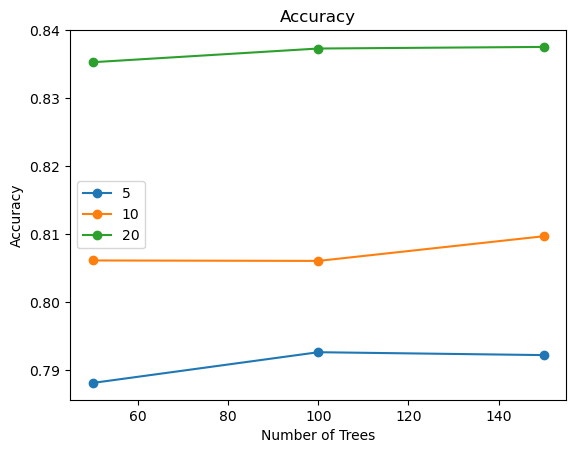

In [32]:
recall_results = pd.DataFrame.from_dict(cross_validate_recall, orient='index')
print(recall_results)
# # Plotting a line plot
recall_results.plot(kind='line', marker='o')

# Display the plot
plt.title('Accuracy')
plt.xlabel('Number of Trees')
plt.ylabel('Accuracy')
plt.show()

# Model 4 : KNN 

In [65]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_smote, y_smote)
# Make predictions on the test data
y_pred = knn.predict(X_OOS_test)
# Evaluate the accuracy of the classifier
print("KNN Accuracy : " , accuracy_score(y_OOS_test, y_pred))
print("KNN Recall : " , recall_score(y_OOS_test, y_pred))
print("KNN Precision : ", precision_score(y_OOS_test,y_pred))
print("KNN F1 : ", f1_score(y_OOS_test,y_pred))


KNN Accuracy :  0.6375430016164463
KNN Recall :  0.4373420919656392
KNN Precision :  0.20984361740817067
KNN F1 :  0.28360776603588106


## Cross Validation for KNN 

In [42]:
# CV in Trees 
# Set Hyperparameter (Lambda) values to cross validate here !!!!!
number_of_neighbours = [1,2,3] 

cross_validate_result = {}
cross_validate_recall = {} 
cross_validate_precision = {} 

for neighbour in number_of_neighbours: 
    print('Number of Neighbours : ', neighbour)
    accuracies = []
    recall_scores = [] 
    precision_scores = [] 
    knn = KNeighborsClassifier(n_neighbors=neighbour)
    for train_index, test_index in cv.split(X_smote):
        # change to loc to define the rows in the dataframe 
        X_cv_train, X_cv_test, y_cv_train, y_cv_test = X_smote.iloc[train_index], X_smote.iloc[test_index], y_smote.iloc[train_index], y_smote.iloc[test_index]
        knn.fit(X_cv_train, y_cv_train)
        y_pred = knn.predict(X_cv_test)

        #Cross-Validation Prediction Error
        score = knn.score(X_cv_test, y_cv_test)
        accuracies.append(score)
        recall_scores.append(recall_score(y_cv_test, y_pred))
        precision_scores.append(precision_score(y_cv_test,y_pred))
    
    cross_validate_result[neighbour] = (sum(accuracies)/len(accuracies))
    cross_validate_recall[neighbour] = (sum(recall_scores)/len(recall_scores))
    cross_validate_precision[neighbour] = (sum(precision_scores)/len(precision_scores))

    print("Accuracy : " + str((sum(accuracies)/len(accuracies))))
    print("Precision : " + str((sum(recall_scores)/len(recall_scores))))
    print("Recall : " + str((sum(precision_scores)/len(precision_scores))))
    print() 
# At the end you'll see what the value of each LASSO paramter is
print('------------------')
print('Accuracy : ', cross_validate_result)
print('Precision : ',cross_validate_precision)
print('Recall : ',cross_validate_recall)

Number of Neighbours :  1
Accuracy : 0.7491306930716343
Precision : 0.7913814929899982
Recall : 0.7297182708745649

Number of Neighbours :  2
Accuracy : 0.7208912490896946
Precision : 0.6143489063987174
Recall : 0.7807035859110011

Number of Neighbours :  3
Accuracy : 0.7284461019183828
Precision : 0.7750719833779053
Recall : 0.7089621936913701

------------------
Accuracy :  {1: 0.7491306930716343, 2: 0.7208912490896946, 3: 0.7284461019183828}
Precision :  {1: 0.7297182708745649, 2: 0.7807035859110011, 3: 0.7089621936913701}
Recall :  {1: 0.7913814929899982, 2: 0.6143489063987174, 3: 0.7750719833779053}


# Model 5 : LASSO and Random Forest

In [63]:
# LASSO 
lasso = linear_model.Lasso()
lasso.fit(X_smote, y_smote)
y_pred = lasso.predict(X_OOS_test)
# turn the continous value into classification via simple >= 0.5 is 1 
y_pred_classification = [1 if x >= 0.5 else 0 for x in y_pred]
print("LASSO score : " , )
print("LASSO Model Recall : " , recall_score(y_OOS_test, y_pred_classification))
print("LASSO Model Precision : ", precision_score(y_OOS_test,y_pred_classification))
print("--")

# See LASSO coefficient that is 0 
lasso_coefficients = pd.Series(lasso.coef_)
non_zero_lasso_coefficients = lasso_coefficients[lasso_coefficients != 0]
# Print the non-zero coefficients
print("Non-zero Lasso Coefficients:")
print(non_zero_lasso_coefficients)


LASSO score : 
LASSO Model Recall :  1.0
LASSO Model Precision :  0.1640485762838314
--
Non-zero Lasso Coefficients:
Series([], dtype: float64)


In [48]:
X_lasso_rf_train = X_smote[['loan_amount','property_value','income']]
X_lasso_rf_test = X_OOS_test[['loan_amount','property_value','income']]
random_forest = RandomForestClassifier(n_estimators = 100, max_depth=5, random_state=0)
random_forest.fit(X_lasso_rf_train, y_smote)
y_pred = random_forest.predict(X_lasso_rf_test)
print("RND Forest Model Recall : " , recall_score(y_OOS_test, y_pred))
print("RND Forest Precision : ", precision_score(y_OOS_test,y_pred))

RND Forest Model Recall :  0.6139464375947449
RND Forest Precision :  0.23610571317528178


## Cross Validation for LASSO and randomforest

In [64]:
# CV in Trees  
# Set Hyperparameter (Lambda) values to cross validate here !!!!! 
max_depth = [2, 3, 4]
number_of_trees = [5,10,15] 

cross_validate_result = create_dictionary(number_of_trees,max_depth)
cross_validate_recall = create_dictionary(number_of_trees,max_depth)
cross_validate_precision = create_dictionary(number_of_trees,max_depth) 

for tree in number_of_trees: 
    for depth in max_depth:
        print('Depth of Tree : ', depth, ' Number of Trees ', tree)
        accuracies = []
        recall_scores = [] 
        precision_scores = [] 
        random_forest_cv = RandomForestClassifier(n_estimators = tree, max_depth=depth)
        for train_index, test_index in cv.split(X_smote):
            # change to loc to define the rows in the dataframe 
            X_cv_train, X_cv_test, y_cv_train, y_cv_test = X_lasso_rf_train.iloc[train_index], X_lasso_rf_train.iloc[test_index], y_smote.iloc[train_index], y_smote.iloc[test_index]
            random_forest_cv.fit(X_cv_train, y_cv_train)
            y_pred = random_forest_cv.predict(X_cv_test)

            #Cross-Validation Prediction Error
            score = random_forest_cv.score(X_cv_test, y_cv_test)
            accuracies.append(score)
            recall_scores.append(recall_score(y_cv_test, y_pred))
            precision_scores.append(precision_score(y_cv_test,y_pred))
        
        cross_validate_result[tree][depth] = (sum(accuracies)/len(accuracies))
        cross_validate_recall[tree][depth] = (sum(recall_scores)/len(recall_scores))
        cross_validate_precision[tree][depth] = (sum(precision_scores)/len(precision_scores))

        print("Accuracy : " + str((sum(accuracies)/len(accuracies))))
        print("Precision : " + str((sum(recall_scores)/len(recall_scores))))
        print("Recall : " + str((sum(precision_scores)/len(precision_scores))))
        print() 
# At the end you'll see what the value of each LASSO paramter is
print('------------------')
print('Accuracy : ', cross_validate_result)
print('Precision : ',cross_validate_precision)
print('Recall : ',cross_validate_recall)

Depth of Tree :  2  Number of Trees  5
Accuracy : 0.5898970807910194
Precision : 0.5600514433592819
Recall : 0.5960859138716283

Depth of Tree :  3  Number of Trees  5
Accuracy : 0.6028969716073906
Precision : 0.6320289001728526
Recall : 0.5975296460241809

Depth of Tree :  4  Number of Trees  5
Accuracy : 0.6066650987112998
Precision : 0.598612368126647
Recall : 0.6089193795794439

Depth of Tree :  2  Number of Trees  10
Accuracy : 0.5953731298159273
Precision : 0.6041965507061027
Recall : 0.593735225239221

Depth of Tree :  3  Number of Trees  10
Accuracy : 0.6015109811705502
Precision : 0.6334501039068922
Recall : 0.5955423320631559

Depth of Tree :  4  Number of Trees  10
Accuracy : 0.6084904183967266
Precision : 0.6153576420941061
Recall : 0.6072664926564537

Depth of Tree :  2  Number of Trees  15
Accuracy : 0.5956700913690367
Precision : 0.5658451977712038
Recall : 0.6022292393645742

Depth of Tree :  3  Number of Trees  15
Accuracy : 0.603589981948197
Precision : 0.629917915617

# Model 6 : Gradient Boosting 

In [67]:
from sklearn.ensemble import GradientBoostingClassifier

clf = GradientBoostingClassifier(n_estimators=100, learning_rate=0.5, max_depth=5, random_state=0).fit(X_smote, y_smote)
y_pred = clf.predict(X_OOS_test)
print("Gradient Boosting Accuracy : " , accuracy_score(y_OOS_test, y_pred))
print("Gradient Boosting Recall : " , recall_score(y_OOS_test, y_pred))
print("Gradient Boosting Precision : ", precision_score(y_OOS_test,y_pred))
print("Gradient Boosting f1 : ", f1_score(y_OOS_test,y_pred))


Gradient Boosting Accuracy :  0.8529862809300783
Gradient Boosting Recall :  0.3309752400202122
Gradient Boosting Precision :  0.5930285196921684
Gradient Boosting f1 :  0.4248419004378141


## Cross Validation for Gradient Boosting

In [47]:
# CV in Trees 
# Set Hyperparameter (Lambda) values to cross validate here !!!!!
learning_rates = [0.01,0.1,0.25,0.5,1]
max_depth = [3,5,10]

cross_validate_result = create_dictionary(learning_rates,max_depth)
cross_validate_recall = create_dictionary(learning_rates,max_depth)
cross_validate_precision = create_dictionary(learning_rates,max_depth) 

for rate in learning_rates: 
    for depth in max_depth:
        print('Depth of Tree : ', depth, ' Learning rate ', rate)
        accuracies = []
        recall_scores = [] 
        precision_scores = [] 
        clf = GradientBoostingClassifier(n_estimators=100, learning_rate=rate, max_depth=depth, random_state=0)
        for train_index, test_index in cv.split(X_smote):
            # change to loc to define the rows in the dataframe 
            X_cv_train, X_cv_test, y_cv_train, y_cv_test = X_smote.iloc[train_index], X_smote.iloc[test_index], y_smote.iloc[train_index], y_smote.iloc[test_index]
            clf.fit(X_cv_train, y_cv_train)
            y_pred = clf.predict(X_cv_test)

            #Cross-Validation Prediction Error
            score = clf.score(X_cv_test, y_cv_test)
            accuracies.append(score)
            recall_scores.append(recall_score(y_cv_test, y_pred))
            precision_scores.append(precision_score(y_cv_test,y_pred))
        
        cross_validate_result[rate][depth] = (sum(accuracies)/len(accuracies))
        cross_validate_recall[rate][depth] = (sum(recall_scores)/len(recall_scores))
        cross_validate_precision[rate][depth] = (sum(precision_scores)/len(precision_scores))

        print("Accuracy : " + str((sum(accuracies)/len(accuracies))))
        print("Precision : " + str((sum(recall_scores)/len(recall_scores))))
        print("Recall : " + str((sum(precision_scores)/len(precision_scores))))
        print() 
# At the end you'll see what the value of each LASSO paramter is
print('------------------')
print('Accuracy : ', cross_validate_result)
print('Precision : ',cross_validate_precision)
print('Recall : ',cross_validate_recall)

Depth of Tree :  3  Number of Trees  150
Accuracy : 0.7767389544932674
Precision : 0.7838862288907824
Recall : 0.7728541682170349

Depth of Tree :  5  Number of Trees  150
Accuracy : 0.812397141022144
Precision : 0.7909555946935181
Recall : 0.8264105389470753

Depth of Tree :  10  Number of Trees  150
Accuracy : 0.8462980591780168
Precision : 0.7990479067475149
Recall : 0.8824633127964786

Depth of Tree :  3  Number of Trees  150
Accuracy : 0.8604672827690175
Precision : 0.826632744327712
Recall : 0.8866323853623914

Depth of Tree :  5  Number of Trees  150
Accuracy : 0.8805887991440562
Precision : 0.844553733411118
Recall : 0.9101551190817162

Depth of Tree :  10  Number of Trees  150
Accuracy : 0.9069967533155536
Precision : 0.8707383710746539
Recall : 0.9388250260087829

Depth of Tree :  3  Number of Trees  150
Accuracy : 0.8768887151213981
Precision : 0.842939654154557
Recall : 0.9043412802512532

Depth of Tree :  5  Number of Trees  150
Accuracy : 0.9058149422751909
Precision : 0.

In [36]:
def plot_result(dataframe, X_axis, Y_axis, title):
    results = pd.DataFrame.from_dict(dataframe, orient='index')
    # # Plotting a line plot
    results.plot(kind='line', marker='o')

    # Display the plot
    plt.title(title)
    plt.xlabel(X_axis)
    plt.ylabel(Y_axis)
    plt.show()

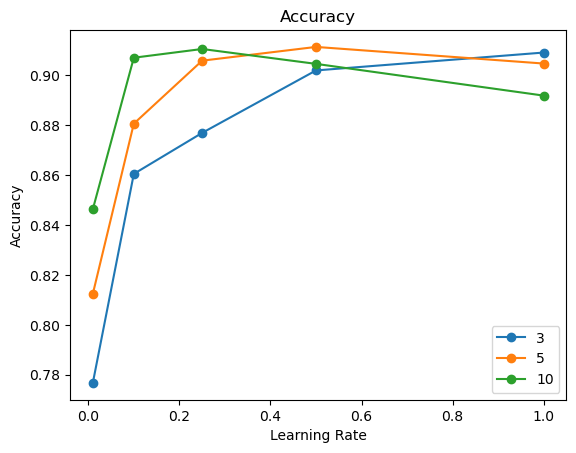

In [62]:
plot_result(cross_validate_result, 'Learning Rate', 'Accuracy', 'Accuracy')

In [58]:
pprint.pprint(cross_validate_result)

{0.01: {3: 0.7767389544932674, 5: 0.812397141022144, 10: 0.8462980591780168},
 0.1: {3: 0.8604672827690175, 5: 0.8805887991440562, 10: 0.9069967533155536},
 0.25: {3: 0.8768887151213981, 5: 0.9058149422751909, 10: 0.9104926439678833},
 0.5: {3: 0.9019045014569806, 5: 0.9113217691845839, 10: 0.9045341418171947},
 1: {3: 0.9090695424294782, 5: 0.9046640863766507, 10: 0.891818992325879}}


# Adaboost

In [69]:
from sklearn.ensemble import AdaBoostClassifier

In [71]:
# Create a weak learner (e.g., Decision Tree)
weak_learner = DecisionTreeClassifier(max_depth=1)

# Create an AdaBoost classifier using the weak learner
adaboost_classifier = AdaBoostClassifier(estimator=weak_learner, n_estimators=100, random_state=42)

# Train the AdaBoost classifier
adaboost_classifier.fit(X_smote, y_smote)

y_pred = clf.predict(X_OOS_test)
print("Adaboost Accuracy : " , accuracy_score(y_OOS_test, y_pred))
print("Adaboost Recall : " , recall_score(y_OOS_test, y_pred))
print("Adaboost Precision : ", precision_score(y_OOS_test,y_pred))
print("Adaboost f1 : ", f1_score(y_OOS_test,y_pred))

Adaboost Accuracy :  0.8529862809300783
Adaboost Recall :  0.3309752400202122
Adaboost Precision :  0.5930285196921684
Adaboost f1 :  0.4248419004378141


## Cross Validation for Adaboost

In [79]:
# CV in Trees 
# Set Hyperparameter (Lambda) values to cross validate here !!!!!
learning_rates = [0]
number_of_trees = [50,100,200,500,1000]

cross_validate_result = create_dictionary(learning_rates,number_of_trees)
cross_validate_recall = create_dictionary(learning_rates,number_of_trees)
cross_validate_precision = create_dictionary(learning_rates,number_of_trees) 

for rate in learning_rates: 
    for tree in number_of_trees:
        print('Depth of Tree : ', tree, ' Learning rate ', rate)
        accuracies = []
        recall_scores = [] 
        precision_scores = [] 
        adaboost_classifier = AdaBoostClassifier(estimator=weak_learner, n_estimators=tree, random_state=0)
        for train_index, test_index in cv.split(X_smote):
            # change to loc to define the rows in the dataframe 
            X_cv_train, X_cv_test, y_cv_train, y_cv_test = X_smote.iloc[train_index], X_smote.iloc[test_index], y_smote.iloc[train_index], y_smote.iloc[test_index]
            adaboost_classifier.fit(X_cv_train, y_cv_train)
            y_pred = adaboost_classifier.predict(X_cv_test)

            #Cross-Validation Prediction Error
            score = adaboost_classifier.score(X_cv_test, y_cv_test)
            accuracies.append(score)
            recall_scores.append(recall_score(y_cv_test, y_pred))
            precision_scores.append(precision_score(y_cv_test,y_pred))
        
        cross_validate_result[rate][tree] = (sum(accuracies)/len(accuracies))
        cross_validate_recall[rate][tree] = (sum(recall_scores)/len(recall_scores))
        cross_validate_precision[rate][tree] = (sum(precision_scores)/len(precision_scores))

        print("Accuracy : " + str((sum(accuracies)/len(accuracies))))
        print("Precision : " + str((sum(recall_scores)/len(recall_scores))))
        print("Recall : " + str((sum(precision_scores)/len(precision_scores))))
        print() 
# At the end you'll see what the value of each LASSO paramter is
print('------------------')
print('Accuracy : ', cross_validate_result)
print('Precision : ',cross_validate_precision)
print('Recall : ',cross_validate_recall)

Depth of Tree :  50  Learning rate  0
Accuracy : 0.8511118759380258
Precision : 0.8349574334837758
Recall : 0.8628386999931793

Depth of Tree :  100  Learning rate  0
Accuracy : 0.8557772004361235
Precision : 0.837668103729779
Recall : 0.8691481835156616

Depth of Tree :  200  Learning rate  0
Accuracy : 0.8599289610400355
Precision : 0.8413045580420008
Recall : 0.8738554228126045

Depth of Tree :  500  Learning rate  0
Accuracy : 0.868900729585459
Precision : 0.848261189281027
Recall : 0.8847872546225078

Depth of Tree :  1000  Learning rate  0
Accuracy : 0.8772228335260761
Precision : 0.8535458326974188
Recall : 0.8959802768162264

------------------
Accuracy :  {0: {50: 0.8511118759380258, 100: 0.8557772004361235, 200: 0.8599289610400355, 500: 0.868900729585459, 1000: 0.8772228335260761}}
Precision :  {0: {50: 0.8628386999931793, 100: 0.8691481835156616, 200: 0.8738554228126045, 500: 0.8847872546225078, 1000: 0.8959802768162264}}
Recall :  {0: {50: 0.8349574334837758, 100: 0.8376681

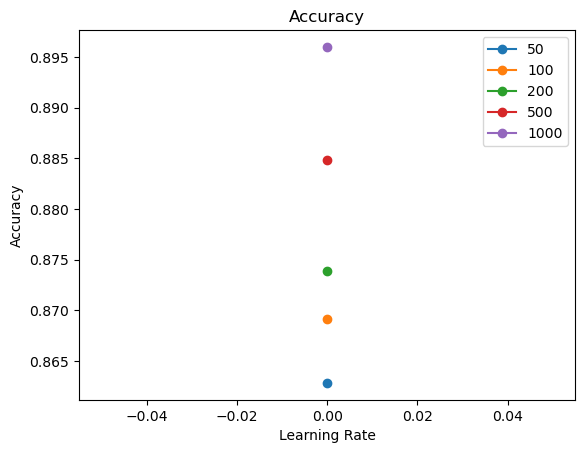

In [80]:
plot_result(cross_validate_precision, 'Learning Rate', 'Accuracy', 'Accuracy')